In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
import warnings
warnings.filterwarnings('ignore')

## 2. Data Loading
Load raw TCGA-SARC multi-omics datasets

In [2]:
print("Loading TCGA-SARC multi-omics datasets...")
print("=" * 50)

# Load multi-omics data
expression_data = pd.read_csv('../RawData/TCGA-SARC.star_tpm.tsv', sep='\t', index_col=0)  # Gene expression (TPM)
methylation_data = pd.read_csv('../RawData/TCGA-SARC.methylation450.tsv', sep='\t', index_col=0)  # DNA methylation
copy_number_data = pd.read_csv('../RawData/TCGA-SARC.gene-level_absolute.tsv', sep='\t', index_col=0) # Copy number variations (absolute)
protein_data = pd.read_csv('../RawData/TCGA-SARC.protein.tsv', sep='\t', index_col=0)  # Protein expression

# Load clinical data with error handling
try:
    phenotype_data = pd.read_csv('../RawData/TCGA-SARC.clinical.tsv', sep='\t', index_col=0)
except Exception as e:
    print(f"Warning: Initial load failed ({e}), attempting with error handling...")
    phenotype_data = pd.read_csv('../RawData/TCGA-SARC.clinical.tsv', sep='\t', index_col=0, on_bad_lines='skip')

print("Raw data shapes:")
print(f"📊 Expression data: {expression_data.shape} (genes x samples)")
print(f"🧬 Methylation data: {methylation_data.shape} (CpG sites x samples)")
print(f"📈 Copy number data: {copy_number_data.shape} (genes x samples)")
print(f"🧪 Protein data: {protein_data.shape} (proteins x samples)")
print(f"🏥 Clinical data: {phenotype_data.shape} (samples x features)")

print("\n✅ Data loading completed!")

Loading TCGA-SARC multi-omics datasets...
Raw data shapes:
📊 Expression data: (60660, 265) (genes x samples)
🧬 Methylation data: (486427, 269) (CpG sites x samples)
📈 Copy number data: (60623, 248) (genes x samples)
🧪 Protein data: (487, 226) (proteins x samples)
🏥 Clinical data: (272, 78) (samples x features)

✅ Data loading completed!
Raw data shapes:
📊 Expression data: (60660, 265) (genes x samples)
🧬 Methylation data: (486427, 269) (CpG sites x samples)
📈 Copy number data: (60623, 248) (genes x samples)
🧪 Protein data: (487, 226) (proteins x samples)
🏥 Clinical data: (272, 78) (samples x features)

✅ Data loading completed!


In [3]:
# Print all columns of the phenotype dataframe
# print(f"Phenotype columns (total: {len(phenotype_data.columns)}):")
# for i, col in enumerate(phenotype_data.columns, start=1):
#     print(f"{i:3d}. {col}")

In [4]:
# Debug: Check protein data values
print("Protein data diagnostics:")
print(f"Shape: {protein_data.shape}")
print(f"NaN count: {protein_data.isna().sum().sum()}")
print(f"Min value: {protein_data.min().min()}")
print(f"Max value: {protein_data.max().max()}")
print(f"Values < -1 (would cause NaN in log2): {(protein_data < -1).sum().sum()}")

Protein data diagnostics:
Shape: (487, 226)
NaN count: 6780
Min value: -5.115518
Max value: 7.977434
Values < -1 (would cause NaN in log2): 7848


In [5]:
# print("RAW DATASETS - First 5 rows and basic info")
# print("="*80)


# print("✅ Raw dataset preview completed.")
# print(phenotype_data.dtypes[:10])
# print("Data types (first 10 clinical features):")
# print(phenotype_data.iloc[:5, :5])
# print("Top 5 rows:")
# print("Columns (first 5 clinical features):", list(phenotype_data.columns[:5]))
# print("Index (first 5 sample IDs):", list(phenotype_data.index[:5]))
# print(f"Shape: {phenotype_data.shape} (rows=samples, cols=features)")
# print(copy_number_data.dtypes[:5])
# print("Data types (first 5 columns):")
# print(copy_number_data.iloc[:5, :5])
# print("Top 5 rows:")
# print("Columns (first 5 sample IDs):", list(copy_number_data.columns[:5]))
# print("Index (first 5 feature IDs):", list(copy_number_data.index[:5]))
# print(f"Shape: {copy_number_data.shape} (rows=features, cols=samples)")
# print(methylation_data.dtypes[:5])
# print("Data types (first 5 columns):")
# print(methylation_data.iloc[:5, :5])
# print("Top 5 rows:")
# print("Columns (first 5 sample IDs):", list(methylation_data.columns[:5]))
# print("Index (first 5 probe IDs):", list(methylation_data.index[:5]))
# print(f"Shape: {methylation_data.shape} (rows=probes, cols=samples)")
# print(expression_data.dtypes[:5])
# print("Data types (first 5 columns):")
# print(expression_data.iloc[:5, :5])
# print("Top 5 rows:")
# print("Columns (first 5 sample IDs):", list(expression_data.columns[:5]))
# print("Index (first 5 gene IDs):", list(expression_data.index[:5]))
# print(f"Shape: {expression_data.shape}")

## 4. Missing Value Assessment
Comprehensive analysis of missing values across all omics

In [6]:
print("Missing value assessment...")
print("=" * 50)

# Check for null values in each omics modality
def assess_missing_values(data, name):
    total_values = data.size
    missing_count = data.isnull().sum().sum()
    missing_percentage = (missing_count / total_values) * 100
    
    # Count entirely NaN rows and columns
    all_nan_rows = data.isna().all(axis=1).sum()
    all_nan_cols = data.isna().all(axis=0).sum()
    
    print(f"\n📊 {name}:")
    print(f"   Total values: {total_values:,}")
    print(f"   Missing values: {missing_count:,}")
    print(f"   Missing percentage: {missing_percentage:.2f}%")
    print(f"   Rows entirely NaN: {all_nan_rows}")
    print(f"   Columns entirely NaN: {all_nan_cols}")
    
    if missing_count > 0:
        print(f"   ⚠️  Contains missing values - preprocessing required")
    else:
        print(f"   ✅ No missing values found")
    
    return missing_count, missing_percentage

# Assess each omics modality
expr_missing, expr_pct = assess_missing_values(expression_data, "Expression Data")
meth_missing, meth_pct = assess_missing_values(methylation_data, "Methylation Data")
cnv_missing, cnv_pct = assess_missing_values(copy_number_data, "Copy Number Data")
prot_missing, prot_pct = assess_missing_values(protein_data, "Protein Data")
pheno_missing, pheno_pct = assess_missing_values(phenotype_data, "Phenotype Data")

# Summary
print(f"\n📋 MISSING VALUE SUMMARY:")
print(f"Expression: {expr_missing:,} ({expr_pct:.2f}%)")
max_value = expression_data.max().max()
min_value = expression_data.min().min()
print(f"Maximum Expression value: {max_value}")
print(f"Minimum Expression value: {min_value}")
print()
print(f"Methylation: {meth_missing:,} ({meth_pct:.2f}%)")
max_value = methylation_data.max().max()
min_value = methylation_data.min().min()
print(f"Maximum Methylation value: {max_value}")
print(f"Minimum Methylation value: {min_value}")
print()
print(f"Copy Number: {cnv_missing:,} ({cnv_pct:.2f}%)")
max_value = copy_number_data.max().max()
min_value = copy_number_data.min().min()
print(f"Maximum CNV value: {max_value}")
print(f"Minimum CNV value: {min_value}")
print()
print(f"Protein: {prot_missing:,} ({prot_pct:.2f}%)")
max_value = protein_data.max().max()
min_value = protein_data.min().min()
print(f"Maximum Protein value: {max_value}")
print(f"Minimum Protein value: {min_value}")
print()
print(f"Phenotype: {pheno_missing:,} ({pheno_pct:.2f}%)")

print("\n✅ Missing value assessment completed!")

Missing value assessment...

📊 Expression Data:
   Total values: 16,074,900
   Missing values: 0
   Missing percentage: 0.00%
   Rows entirely NaN: 0
   Columns entirely NaN: 0
   ✅ No missing values found

📊 Methylation Data:
   Total values: 130,848,863
   Missing values: 21,510,063
   Missing percentage: 16.44%
   Rows entirely NaN: 64826
   Columns entirely NaN: 0
   ⚠️  Contains missing values - preprocessing required

📊 Copy Number Data:
   Total values: 15,034,504
   Missing values: 1,002,304
   Missing percentage: 6.67%
   Rows entirely NaN: 3383
   Columns entirely NaN: 0
   ⚠️  Contains missing values - preprocessing required

📊 Protein Data:
   Total values: 110,062
   Missing values: 6,780
   Missing percentage: 6.16%
   Rows entirely NaN: 30
   Columns entirely NaN: 0
   ⚠️  Contains missing values - preprocessing required

📊 Phenotype Data:
   Total values: 21,216
   Missing values: 4,286
   Missing percentage: 20.20%
   Rows entirely NaN: 0
   Columns entirely NaN: 0
   

In [7]:
print("Dropping rows with entirely NaN values...")
print("=" * 50)

def drop_all_nan_rows(data, name):
    """Drop rows that are entirely NaN and report the change."""
    before_rows = data.shape[0]
    all_nan_mask = data.isna().all(axis=1)
    all_nan_count = all_nan_mask.sum()
    
    # Drop entirely NaN rows
    data_clean = data.loc[~all_nan_mask]
    after_rows = data_clean.shape[0]
    
    print(f"\n📊 {name}:")
    print(f"   Rows before: {before_rows:,}")
    print(f"   Entirely NaN rows dropped: {all_nan_count:,}")
    print(f"   Rows after: {after_rows:,}")
    
    # Check remaining NaN status
    remaining_nan = data_clean.isna().sum().sum()
    remaining_all_nan_rows = data_clean.isna().all(axis=1).sum()
    print(f"   Remaining NaN values: {remaining_nan:,}")
    print(f"   Remaining entirely NaN rows: {remaining_all_nan_rows}")
    
    if all_nan_count > 0:
        print(f"   ✅ Dropped {all_nan_count} entirely NaN rows")
    else:
        print(f"   ✅ No entirely NaN rows found")
    
    return data_clean

# Drop entirely NaN rows from each omics
expression_data = drop_all_nan_rows(expression_data, "Expression Data")
methylation_data = drop_all_nan_rows(methylation_data, "Methylation Data")
copy_number_data = drop_all_nan_rows(copy_number_data, "Copy Number Data")
protein_data = drop_all_nan_rows(protein_data, "Protein Data")

print("\n" + "=" * 50)
print("✅ Entirely NaN row removal completed!")

Dropping rows with entirely NaN values...

📊 Expression Data:
   Rows before: 60,660
   Entirely NaN rows dropped: 0
   Rows after: 60,660
   Remaining NaN values: 0
   Remaining entirely NaN rows: 0
   ✅ No entirely NaN rows found

📊 Methylation Data:
   Rows before: 486,427
   Entirely NaN rows dropped: 64,826
   Rows after: 421,601
   Remaining NaN values: 4,071,869
   Remaining entirely NaN rows: 0
   ✅ Dropped 64826 entirely NaN rows

📊 Methylation Data:
   Rows before: 486,427
   Entirely NaN rows dropped: 64,826
   Rows after: 421,601
   Remaining NaN values: 4,071,869
   Remaining entirely NaN rows: 0
   ✅ Dropped 64826 entirely NaN rows

📊 Copy Number Data:
   Rows before: 60,623
   Entirely NaN rows dropped: 3,383
   Rows after: 57,240
   Remaining NaN values: 163,320
   Remaining entirely NaN rows: 0
   ✅ Dropped 3383 entirely NaN rows

📊 Protein Data:
   Rows before: 487
   Entirely NaN rows dropped: 30
   Rows after: 457
   Remaining NaN values: 0
   Remaining entirely NaN

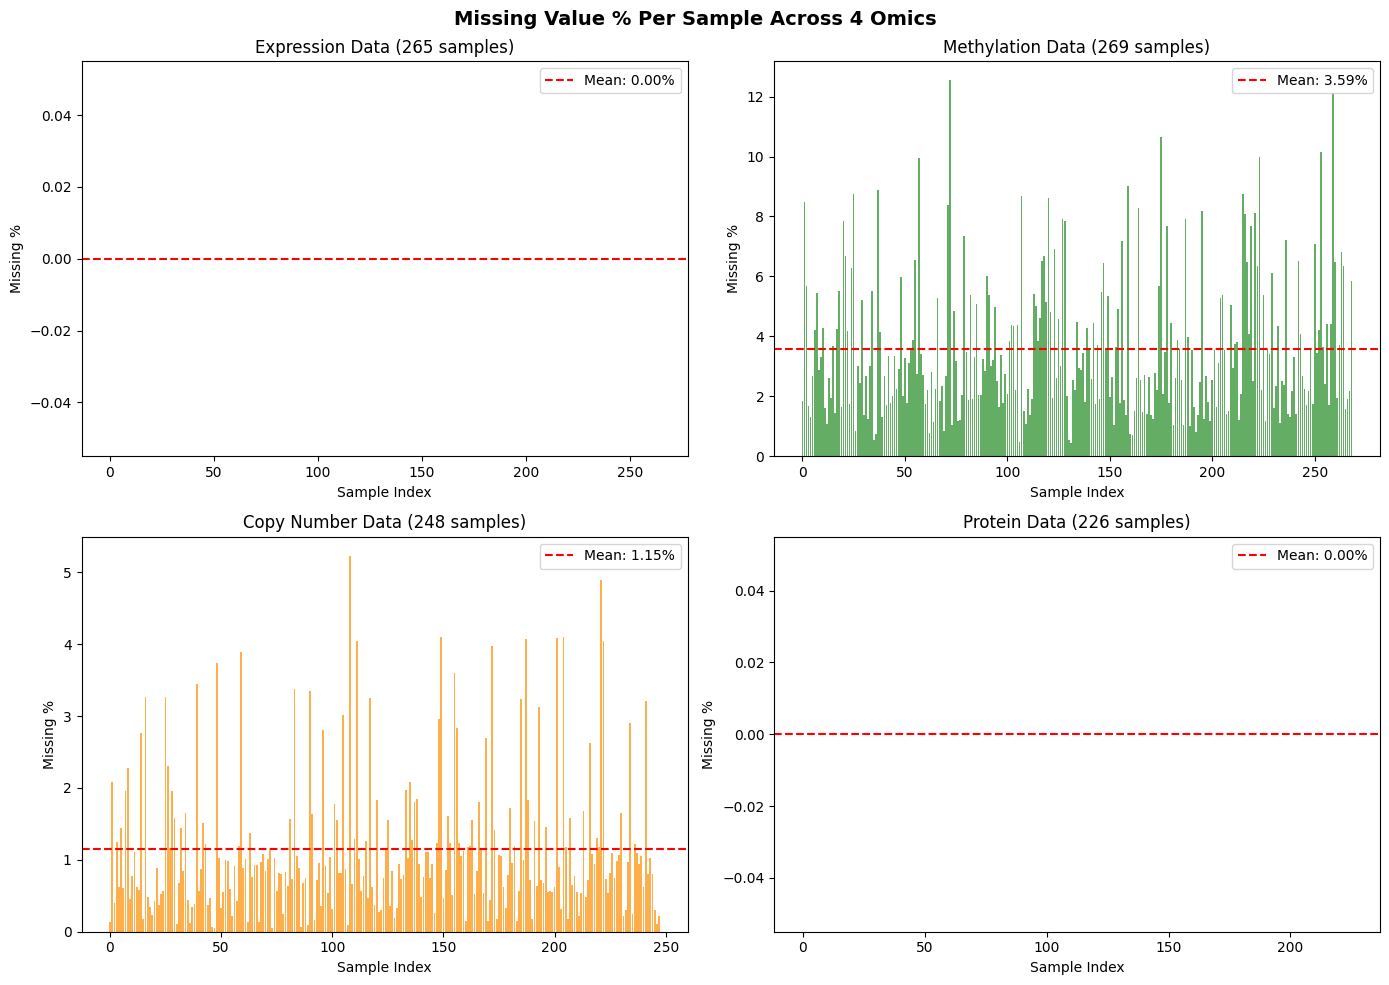


📊 Missing Value Summary Per Sample:
Expression:  Mean=0.00%, Max=0.00%, Samples with >20% missing: 0
Methylation: Mean=3.59%, Max=12.55%, Samples with >20% missing: 0
CNV:         Mean=1.15%, Max=5.23%, Samples with >20% missing: 0
Protein:     Mean=0.00%, Max=0.00%, Samples with >20% missing: 0


In [8]:
import matplotlib.pyplot as plt

# Calculate missing value % per sample (column) for each omics
expr_missing_pct = (expression_data.isna().sum(axis=0) / expression_data.shape[0]) * 100
meth_missing_pct = (methylation_data.isna().sum(axis=0) / methylation_data.shape[0]) * 100
cnv_missing_pct = (copy_number_data.isna().sum(axis=0) / copy_number_data.shape[0]) * 100
prot_missing_pct = (protein_data.isna().sum(axis=0) / protein_data.shape[0]) * 100

# Create figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Missing Value % Per Sample Across 4 Omics', fontsize=14, fontweight='bold')

# Expression
axes[0, 0].bar(range(len(expr_missing_pct)), expr_missing_pct.values, color='steelblue', alpha=0.7)
axes[0, 0].set_title(f'Expression Data ({len(expr_missing_pct)} samples)')
axes[0, 0].set_xlabel('Sample Index')
axes[0, 0].set_ylabel('Missing %')
axes[0, 0].axhline(y=expr_missing_pct.mean(), color='red', linestyle='--', label=f'Mean: {expr_missing_pct.mean():.2f}%')
axes[0, 0].legend()

# Methylation
axes[0, 1].bar(range(len(meth_missing_pct)), meth_missing_pct.values, color='forestgreen', alpha=0.7)
axes[0, 1].set_title(f'Methylation Data ({len(meth_missing_pct)} samples)')
axes[0, 1].set_xlabel('Sample Index')
axes[0, 1].set_ylabel('Missing %')
axes[0, 1].axhline(y=meth_missing_pct.mean(), color='red', linestyle='--', label=f'Mean: {meth_missing_pct.mean():.2f}%')
axes[0, 1].legend()

# CNV
axes[1, 0].bar(range(len(cnv_missing_pct)), cnv_missing_pct.values, color='darkorange', alpha=0.7)
axes[1, 0].set_title(f'Copy Number Data ({len(cnv_missing_pct)} samples)')
axes[1, 0].set_xlabel('Sample Index')
axes[1, 0].set_ylabel('Missing %')
axes[1, 0].axhline(y=cnv_missing_pct.mean(), color='red', linestyle='--', label=f'Mean: {cnv_missing_pct.mean():.2f}%')
axes[1, 0].legend()

# Protein
axes[1, 1].bar(range(len(prot_missing_pct)), prot_missing_pct.values, color='purple', alpha=0.7)
axes[1, 1].set_title(f'Protein Data ({len(prot_missing_pct)} samples)')
axes[1, 1].set_xlabel('Sample Index')
axes[1, 1].set_ylabel('Missing %')
axes[1, 1].axhline(y=prot_missing_pct.mean(), color='red', linestyle='--', label=f'Mean: {prot_missing_pct.mean():.2f}%')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n📊 Missing Value Summary Per Sample:")
print(f"Expression:  Mean={expr_missing_pct.mean():.2f}%, Max={expr_missing_pct.max():.2f}%, Samples with >20% missing: {(expr_missing_pct > 20).sum()}")
print(f"Methylation: Mean={meth_missing_pct.mean():.2f}%, Max={meth_missing_pct.max():.2f}%, Samples with >20% missing: {(meth_missing_pct > 20).sum()}")
print(f"CNV:         Mean={cnv_missing_pct.mean():.2f}%, Max={cnv_missing_pct.max():.2f}%, Samples with >20% missing: {(cnv_missing_pct > 20).sum()}")
print(f"Protein:     Mean={prot_missing_pct.mean():.2f}%, Max={prot_missing_pct.max():.2f}%, Samples with >20% missing: {(prot_missing_pct > 20).sum()}")

In [9]:
from sklearn.feature_selection import VarianceThreshold
import numpy as np
import pandas as pd

# --- Expression preprocessing ---
expr_log = np.log2(expression_data + 1)
expr_selector = VarianceThreshold(threshold=0.01)
expression_data_scaled = pd.DataFrame(
    expr_selector.fit_transform(expr_log.T).T,
    index=expr_log.index[expr_selector.get_support()],
    columns=expr_log.columns
)
expr_mask = expr_selector.get_support()

# --- Methylation preprocessing ---
methylation_filtered = methylation_data.dropna(thresh=0.20 * methylation_data.shape[1], axis=0)
methylation_imputed = methylation_filtered.apply(lambda r: r.fillna(r.median()), axis=1)
meth_m = np.log2(methylation_imputed / (1 - methylation_imputed))
meth_selector = VarianceThreshold(threshold=0.01)
methylation_scaled = pd.DataFrame(
    meth_selector.fit_transform(meth_m.T).T,
    index=meth_m.index[meth_selector.get_support()],
    columns=meth_m.columns
)
meth_mask = meth_selector.get_support()

# --- CNV preprocessing ---
cnv_filtered = copy_number_data.loc[copy_number_data.isnull().mean(axis=1) < 0.2]
cnv_imputed = cnv_filtered.apply(lambda r: r.fillna(r.median()), axis=1)
cnv_clipped = cnv_imputed.clip(lower=0.05, upper=6)
log_cnv = np.log2(cnv_clipped / 2)
cnv_selector = VarianceThreshold(threshold=0.01)
copy_number_scaled = pd.DataFrame(
    cnv_selector.fit_transform(log_cnv.T).T,
    index=log_cnv.index[cnv_selector.get_support()],
    columns=log_cnv.columns
)
cnv_mask = cnv_selector.get_support()

protein_filtered = protein_data.loc[protein_data.isnull().mean(axis=1) < 0.2]
protein_imputed = protein_filtered.apply(lambda r: r.fillna(r.median()), axis=1)
prot_selector = VarianceThreshold(threshold=0.01)
protein_scaled = pd.DataFrame(
    prot_selector.fit_transform(protein_imputed.T).T,
    index=protein_imputed.index[prot_selector.get_support()],
    columns=protein_imputed.columns
)
prot_mask = prot_selector.get_support()

print("Feature counts after filtering:")
print("Expression:", expression_data_scaled.shape)
print("Methylation:", methylation_scaled.shape)
print("CNV:", copy_number_scaled.shape)
print("Protein:", protein_scaled.shape)

Feature counts after filtering:
Expression: (44750, 265)
Methylation: (419546, 269)
CNV: (56751, 248)
Protein: (453, 226)


In [10]:
print("Processing Phenotype Data...")
print("=" * 50)

# Define subtype column and selected subtypes
subtype_column = 'primary_diagnosis.diagnoses'
selected_subtypes = [
    'Leiomyosarcoma, NOS',
    'Dedifferentiated liposarcoma',
    'Undifferentiated sarcoma',
    'Fibromyxosarcoma'
]

print(f"🎯 Target column: '{subtype_column}'")
print(f"📊 Original subtype distribution:")
subtype_counts = phenotype_data[subtype_column].value_counts()
for subtype, count in subtype_counts.items():
    marker = "✅" if subtype in selected_subtypes else "❌"
    print(f"   {marker} {subtype}: {count}")

# Filter to selected subtypes only
print(f"\n🔄 Filtering to selected subtypes...")
before_filter = len(phenotype_data)
phenotype_data = phenotype_data[phenotype_data[subtype_column].isin(selected_subtypes)]
after_filter = len(phenotype_data)
removed_samples = before_filter - after_filter
print(f"📊 Removed {removed_samples} samples ({removed_samples/before_filter*100:.1f}%)")
print(f"📊 Remaining samples: {after_filter}")

# Check for missing subtypes
missing_subtypes = phenotype_data[subtype_column].isnull().sum()
print(f"\n🔍 Missing values in subtype column: {missing_subtypes}")

if missing_subtypes > 0:
    print("🔄 Removing samples with missing subtypes...")
    phenotype_data_clean = phenotype_data.dropna(subset=[subtype_column])
    print(f"📊 Removed {missing_subtypes} samples with missing subtypes")
else:
    phenotype_data_clean = phenotype_data.copy()
    print("✅ No missing subtypes found")

print(f"📊 Clean phenotype data shape: {phenotype_data_clean.shape}")

# Encode subtypes as numeric labels
print("\n🔄 Encoding subtypes as numeric labels...")
subtypes = phenotype_data_clean[subtype_column]
label_encoder = LabelEncoder()
subtype_encoded = label_encoder.fit_transform(subtypes)

# Create and display encoding mapping
subtype_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f"📋 Subtype encoding mapping:")
for subtype, encoded in subtype_mapping.items():
    print(f"   {encoded}: {subtype}")

# Convert to pandas Series for easy handling
subtype_encoded = pd.Series(subtype_encoded, index=subtypes.index, name='subtype_encoded')

print(f"\n📊 Encoded subtype distribution:")
encoded_counts = subtype_encoded.value_counts().sort_index()
for label, count in encoded_counts.items():
    subtype_name = label_encoder.classes_[label]
    print(f"   Class {label}: {count} samples ({subtype_name})")

print("\n✅ Phenotype data processing completed!")

Processing Phenotype Data...
🎯 Target column: 'primary_diagnosis.diagnoses'
📊 Original subtype distribution:
   ✅ Leiomyosarcoma, NOS: 109
   ✅ Dedifferentiated liposarcoma: 60
   ✅ Undifferentiated sarcoma: 35
   ✅ Fibromyxosarcoma: 25
   ❌ Malignant fibrous histiocytoma: 12
   ❌ Malignant peripheral nerve sheath tumor: 10
   ❌ Synovial sarcoma, spindle cell: 6
   ❌ Giant cell sarcoma: 3
   ❌ Myxoid leiomyosarcoma: 3
   ❌ Synovial sarcoma, NOS: 2
   ❌ Pleomorphic liposarcoma: 2
   ❌ Synovial sarcoma, biphasic: 2
   ❌ Liposarcoma, well differentiated: 1
   ❌ Abdominal fibromatosis: 1
   ❌ Aggressive fibromatosis: 1

🔄 Filtering to selected subtypes...
📊 Removed 43 samples (15.8%)
📊 Remaining samples: 229

🔍 Missing values in subtype column: 0
✅ No missing subtypes found
📊 Clean phenotype data shape: (229, 78)

🔄 Encoding subtypes as numeric labels...
📋 Subtype encoding mapping:
   0: Dedifferentiated liposarcoma
   1: Fibromyxosarcoma
   2: Leiomyosarcoma, NOS
   3: Undifferentiated sa

In [11]:
import numpy as np

for name, df in [
    ("expression_data_scaled", expression_data_scaled),
    ("methylation_scaled", methylation_scaled),
    ("copy_number_scaled", copy_number_scaled),
    ("protein_scaled", protein_scaled),
    ("phenotype_data_clean", phenotype_data_clean)
]:
    has_inf = np.isinf(df.select_dtypes(include=[np.number])).any().any()
    print(f"Any inf values in {name}? {has_inf}")

print("NaN counts:", expression_data_scaled.isna().sum().sum(),
      methylation_scaled.isna().sum().sum(),
      copy_number_scaled.isna().sum().sum(),
      protein_scaled.isna().sum().sum())

Any inf values in expression_data_scaled? False
Any inf values in methylation_scaled? False
Any inf values in copy_number_scaled? False
Any inf values in protein_scaled? False
Any inf values in phenotype_data_clean? False
Any inf values in methylation_scaled? False
Any inf values in copy_number_scaled? False
Any inf values in protein_scaled? False
Any inf values in phenotype_data_clean? False
NaN counts: 0 0 0 0
NaN counts: 0 0 0 0


Common samples across all 4 omics: 210
Expression: (44750, 210), Methylation: (419546, 210), CNV: (56751, 210), Protein: (453, 210)
Expression: (44750, 210), Methylation: (419546, 210), CNV: (56751, 210), Protein: (453, 210)


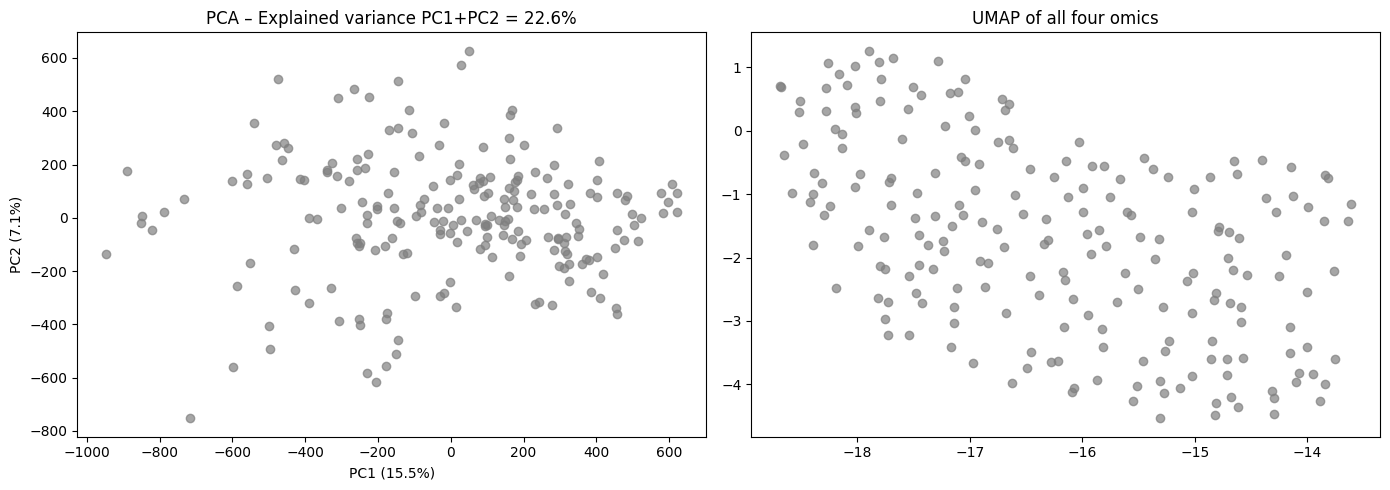

In [14]:
from sklearn.decomposition import PCA
# Install & import umap (umap-learn) if missing (works in Jupyter)
try:
    import umap
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "umap-learn"])
    import umap
import seaborn as sns

# Find common samples across all 4 omics
common_samples = list(
    set(expression_data_scaled.columns) & 
    set(methylation_scaled.columns) & 
    set(copy_number_scaled.columns) & 
    set(protein_scaled.columns)
)
print(f"Common samples across all 4 omics: {len(common_samples)}")

# Filter each omics to common samples only
expr_common = expression_data_scaled[common_samples]
meth_common = methylation_scaled[common_samples]
cnv_common = copy_number_scaled[common_samples]
prot_common = protein_scaled[common_samples]

print(f"Expression: {expr_common.shape}, Methylation: {meth_common.shape}, CNV: {cnv_common.shape}, Protein: {prot_common.shape}")

# Concatenate all omics (samples × features)
X_all = np.hstack([
    expr_common.values.T, 
    meth_common.values.T, 
    cnv_common.values.T, 
    prot_common.values.T
])

# PCA
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_all)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.scatter(X_pca[:,0], X_pca[:,1], c='gray', alpha=0.7)
plt.title(f'PCA – Explained variance PC1+PC2 = {pca.explained_variance_ratio_[:2].sum():.1%}')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')

# UMAP
reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.3)
X_umap = reducer.fit_transform(X_all)

plt.subplot(1,2,2)
plt.scatter(X_umap[:,0], X_umap[:,1], c='gray', alpha=0.7)
plt.title('UMAP of all four omics')
plt.tight_layout()
plt.show()

In [15]:
def quick_quality_report(df, name):
    print(f"\n=== {name} ===")
    print(f"Shape                  : {df.shape}")
    print(f"NaNs total             : {df.isna().sum().sum()}")
    print(f"NaNs per sample (max)  : {df.isna().sum(axis=0).max()}")
    print(f"NaNs per feature (max) : {df.isna().sum(axis=1).max()}")
    print(f"Infinite values        : {np.isinf(df.select_dtypes(include=np.number)).sum().sum()}")
    print(f"Duplicate features     : {df.index.duplicated().sum()}")
    print(f"Duplicate samples      : {df.columns.duplicated().sum()}")
    print(f"Constant features      : {(df.nunique() == 1).sum()}")
    print(f"Min / Max              : {df.min().min():.3f} / {df.max().max():.3f}")

quick_quality_report(expression_data_scaled,   "Expression")
quick_quality_report(methylation_scaled,       "Methylation")
quick_quality_report(copy_number_scaled,       "CNV")
quick_quality_report(protein_scaled,           "Protein")


=== Expression ===
Shape                  : (44750, 265)
NaNs total             : 0
NaNs per sample (max)  : 0
NaNs per feature (max) : 0
Infinite values        : 0
Duplicate features     : 0
Duplicate samples      : 0
Constant features      : 0
Min / Max              : 0.000 / 4.191

=== Methylation ===
Shape                  : (419546, 269)
Constant features      : 0
Min / Max              : 0.000 / 4.191

=== Methylation ===
Shape                  : (419546, 269)
NaNs total             : 0
NaNs per sample (max)  : 0
NaNs total             : 0
NaNs per sample (max)  : 0
NaNs per feature (max) : 0
NaNs per feature (max) : 0
Infinite values        : 0
Duplicate features     : 0
Duplicate samples      : 0
Infinite values        : 0
Duplicate features     : 0
Duplicate samples      : 0
Constant features      : 0
Constant features      : 0
Min / Max              : -8.023 / 7.991

=== CNV ===
Shape                  : (56751, 248)
NaNs total             : 0
NaNs per sample (max)  : 0
NaNs 

## 10. Dataset Preview
Display first 5 rows of all processed datasets

In [ ]:
# print("DATASET PREVIEW: First 5 rows of all processed datasets")
# print("=" * 80)

# # Expression Data Preview
# print("\n📊 EXPRESSION DATA (Log2-transformed, variance filtered)")
# print("-" * 60)
# print(f"Shape: {expression_data_scaled.shape} (genes x samples)")
# print("First 5 genes, first 5 samples:")
# print(expression_data_scaled.iloc[:5, :5])
# print(f"Data type: {expression_data_scaled.dtypes.iloc[0]}")
# print(f"Value range: [{expression_data_scaled.min().min():.3f}, {expression_data_scaled.max().max():.3f}]")

# # Methylation Data Preview  
# print("\n🧬 METHYLATION DATA (M-values, variance filtered)")
# print("-" * 60)
# print(f"Shape: {methylation_scaled.shape} (CpG sites x samples)")
# print("First 5 CpG sites, first 5 samples:")
# print(methylation_scaled.iloc[:5, :5])
# print(f"Data type: {methylation_scaled.dtypes.iloc[0]}")
# print(f"Value range: [{methylation_scaled.min().min():.3f}, {methylation_scaled.max().max():.3f}]")

# # Copy Number Data Preview
# print("\n📈 COPY NUMBER DATA (Log2 ratio, variance filtered)")
# print("-" * 60)
# print(f"Shape: {copy_number_scaled.shape} (regions x samples)")
# print("First 5 regions, first 5 samples:")
# print(copy_number_scaled.iloc[:5, :5])
# print(f"Data type: {copy_number_scaled.dtypes.iloc[0]}")
# print(f"Value range: [{copy_number_scaled.min().min():.3f}, {copy_number_scaled.max().max():.3f}]")

# # Protein Data Preview
# print("\n🧪 PROTEIN DATA (Log2-transformed, variance filtered)")
# print("-" * 60)
# print(f"Shape: {protein_scaled.shape} (proteins x samples)")
# print("First 5 proteins, first 5 samples:")
# print(protein_scaled.iloc[:5, :5])
# print(f"Data type: {protein_scaled.dtypes.iloc[0]}")
# print(f"Value range: [{protein_scaled.min().min():.3f}, {protein_scaled.max().max():.3f}]")

# # Phenotype Data Preview
# print("\n🏥 PHENOTYPE DATA (Clinical features)")
# print("-" * 60)
# print(f"Shape: {phenotype_data_clean.shape} (samples x features)")
# print("First 5 samples, first 5 clinical features:")
# print(phenotype_data_clean.iloc[:5, :5])
# print(f"Total clinical features: {phenotype_data_clean.shape[1]}")

# # Subtype Labels Preview
# print("\n🎯 SUBTYPE LABELS (Encoded)")
# print("-" * 60)
# print(f"Shape: {subtype_encoded.shape} (samples)")
# print("First 10 samples with their encoded subtypes:")
# for i in range(min(10, len(subtype_encoded))):
#     sample_id = subtype_encoded.index[i]
#     encoded_label = subtype_encoded.iloc[i]
#     original_subtype = label_encoder.inverse_transform([encoded_label])[0]
#     print(f"   {sample_id}: {encoded_label} ({original_subtype})")

# print(f"\nLabel distribution:")
# for label in sorted(subtype_encoded.unique()):
#     count = (subtype_encoded == label).sum()
#     subtype_name = label_encoder.inverse_transform([label])[0]
#     print(f"   Class {label}: {count} samples ({subtype_name})")

# print("\n✅ Dataset preview completed!")

## 11. Data Export
Save processed datasets for downstream analysis

In [ ]:
# print("Exporting Processed Data...")
# print("=" * 50)

# # Define output directory
# output_dir = "../NewDatasets/"
# # Save main processed files (features as rows, samples as columns)
# expression_data_scaled.to_csv(f"{output_dir}processed_expression_4O.csv", mode='w')
# methylation_scaled.to_csv(f"{output_dir}processed_methylation_4O.csv", mode='w')
# copy_number_scaled.to_csv(f"{output_dir}processed_cnv_4O.csv", mode='w')
# protein_scaled.to_csv(f"{output_dir}processed_protein_4O.csv", mode='w')
# phenotype_data_clean.to_csv(f"{output_dir}processed_phenotype_4O.csv", mode='w')
# subtype_encoded.to_csv(f"{output_dir}processed_labels_4Omics_4O.csv", header=True, mode='w')